# Exploring Lewis Grassic Gibbon First Editions
Created August-September 2020 for the National Library of Scotland's Data Foundry by Lucy Havens, Digital Library Research Intern

### About the Lewis Grassic Gibbon First Editions Dataset
Lewis Grassic Gibbon is an early 20th century Scottish novelist who also published under his birth name, James Leslie Mitchell.  He was an  prolific writer for the short period of time (5 years) that he published fiction and non-fiction, and the NLS collection contains first editions of all his published books.  Gibbon's stories often featured strong central female characters, unusual for an early 20th century writer.  Gibbon's literary influence continues to be felt today: his book A Sunset Song was voted Scotland's favorite novel in 2016, and contemporary Scottish writers such as Ali Smith and E.L. Kennedy have noted Gibbon's influence on their own writing.

* Data format: digitised text
* Data creation process: Optical Character Recognition (OCR)
* Data source: https://data.nls.uk/data/digitised-collections/lewis-grassic-gibbon-first-editions/
***
### Table of Contents
0. [Preparation](#0.-Preparation)
1. [Data Cleaning and Standardisation](#1.-Data-Cleaning-and-Standardisation)
2. [Summary Statistics](#2.-Summary-Statistics)
3. [Exploratory Analysis](#3.-Exploratory-Analysis)
***

### 0. Preparation
Import libraries to use for cleaning, summarising and exploring the data:

In [2]:
# To prevent SSL certificate failure
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Libraries for data loading
import pandas as pd
import numpy as np
import string
import re
from collections import defaultdict

# Libraries for visualization
import altair as alt
import matplotlib.pyplot as plt

# Libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags
from nltk.draw.dispersion import dispersion_plot as displt

[nltk_data] Downloading package punkt to /Users/lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /Users/lucy/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


To explore the text in the Lewis Grassic Gibbon First Editions collection, we'll mainly use the **Natural Language Toolkit (NLTK)**, a library written for the programming language Python.

The nls-text-gibbon folder (downloadable as *Just the text* data from the website at the top of this notebook) contains TXT files of digitised text, with numerical names, as well as a CSV inventory file and a TXT ReadMe file.  Load only the TXT files of digitised text and **tokenise** the text (which splits the text into a list of its individual words and punctuation in the order they appear):

In [3]:
corpus_folder = 'data/nls-text-gibbon/'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*', encoding='latin1')
corpus_tokens = wordlists.words()
print(corpus_tokens[100:115])

['BY', 'ROBERT', 'MACLEHOSE', 'AND', 'CO', '.', 'LTD', '.', 'THE', 'UNIVERSITY', 'PRESS', ',', 'GLASGOW', 'ALL', 'RIGHTS']


*Note: If you'd like to see how to specify a single TXT file to load as data, check out the Jupyter Notebook for the Britain and UK Handbooks!*

It's hard to get a sense of how accurately the text has been digitised from this list of 15 tokens, so let's look at one of these words in context.  To see phrases in which "Scots" is used, we can use the concordance() method:

In [4]:
t = Text(corpus_tokens)
t.concordance("Scots")

Displaying 25 of 72 matches:
UTHOR Novels forming the trilogy , A Scots Quair Part I . Sunset Song ( 1932 ) 
igins of that son . He had the usual Scots passion for educationâ  that passi
Â ¬ thing of the same quality , this Scots desire and pride in education , that
hood . Because second - sight in the Scots was a fiction not yet invented in th
us these were the lesser gods of the Scots pantheon , witches and wizards and k
 the ambition and intention of every Scots farmer to produce at least one son w
ad litde relevance to religion . The Scots are not a religious people : long be
is the function and privilege of the Scots minister : he is less a priest than 
e tenebrous imaginings of fear . The Scots ballads could have widened his geogr
 and climes , where beasts were un - Scots and untamed , and in blue waters str
racteristic of one great division of Scots as Burns was of another . He saw the
scular , with the solid frame of the Scots peasant redeemed of its usual squatn
 appreciati

There are some mistakes but not too many!

Note how NLTK's ``concordance`` method works: the word "Scots" appears with different meanings, sometimes referring to the language, other times referring to the people.  NLTK has a tagging method that identifies the parts of speech in sentences, so if we wanted to focus on the language Scots, we could look for instances of Scots being used as a noun.  If we wanted to focus on the people Scots, we could look for instances of Scots being used as an adjective.  This method wouldn't return perfect results, though.  For example, we could improve our results by checking for instances of "Scots" being used as an adjective before the word "dialects," for example.

We'll wait to dive into this sort of text analysis until a bit later, though!  

#### 0.1 Dataset Size
First, let's get a sense of how much data (in this case, text) we have in the *Lewis Grassic Gibbon First Editions* (LGG) dataset:

In [5]:
def corpusStatistics(plaintext_corpus_read_lists):
    total_chars = 0
    total_tokens = 0
    total_sents = 0
    total_files = 0
    for fileid in plaintext_corpus_read_lists.fileids():
        total_chars += len(plaintext_corpus_read_lists.raw(fileid))
        total_tokens += len(plaintext_corpus_read_lists.words(fileid))
        total_sents += len(plaintext_corpus_read_lists.sents(fileid))
        total_files += 1
    print("Estimated total...")
    print("  Characters in LGG Data:", total_chars)
    print("  Tokens in LGG Data:", total_tokens)
    print("  Sentences in LGG Data:", total_sents)
    print("  Files in LGG Data:", total_files)

corpusStatistics(wordlists)

Estimated total...
  Characters in LGG Data: 7068578
  Tokens in LGG Data: 1506095
  Sentences in LGG Data: 70821
  Files in LGG Data: 16


Note that I've print ``Tokens`` rather than words, though the NLTK method used to count those was ``.words()``.  This is because words in NLTK include punctuation marks and digits, in addition to alphabetic words.

#### 0.2 Identifying Subsets of the Data
Next, we'll create two subsets of the data, one for each journal.  To do so we first need to load the inventory (CSV file) that lists which file name corresponds with which journal.  When you open the CSV file in Microsoft Excel or a text editor, you can see that there are no column names.  The Python library [Pandas](https://pandas.pydata.org/docs/), which reads CSV files, calls these column names the ``header``.  When we use Pandas to read the inventory, we'll create our own header by specifying that the CSV file as ``None`` and providing a list of column ``names``.

When Pandas (abbreviated ``pd`` when we loaded libraries in the first cell of this notebook) reads a CSV file, it creates a table called a **dataframe** from that data.  Let's see what the Gibbon inventory dataframe looks like:

In [6]:
df = pd.read_csv('data/nls-text-gibbon/gibbon-inventory.csv', header=None, names=['fileid', 'title'])
df

,fileid,title
0,205174241.txt,Niger - R.176.i
1,205174242.txt,Thirteenth disciple - Vts.137.d
2,205174243.txt,Three go back - Vts.152.f.22
3,205174244.txt,Calends of Cairo - Vts.153.c.16
4,205174245.txt,Lost trumpet - Vts.143.j.8
5,205174246.txt,Image and superscription - Vts.118.l.16
6,205174247.txt,Spartacus - Vts.6.k.19
7,205174248.txt,"Persian dawns, Egyptian nights - Vts.148.d.8"
8,205174249.txt,Scots quair - Cloud howe - NF.523.b.30
9,205174250.txt,Scots quair - Grey granite - NF.523.b.31


Since we only have 16 files, we returned the entire dataframe above.  With larger dataframes you may wish to use  ``df.head()`` or ``df.tail()`` to print only the first 5 or last 5 rows of your CSV file (both of which will include the column names in the dataframe's header).

Now that we created a dataframe, if we want to determine the title of a Gibbon work based on it's file ID, we can use the following code:

In [7]:
# obtain a list of all file IDs
fileids = list(df["fileid"])
print("List of file IDs:\n", fileids)
print()

# obtain a list of all titles
titles = list(df["title"])
print("List of titles:\n", titles)
print()

# create a dictionary where the keys are file IDs and the values are titles
lgg_dict = dict(zip(fileids, titles))
print("Dictionary of file IDs and titles:\n", lgg_dict)
print()

# pick a file ID by its index number
a_file_id = fileids[10]

# get the title corresponding with the file ID in the dataframe
print("The title for the file ID at index 10:\n", lgg_dict[a_file_id])
print()

List of file IDs:
 ['205174241.txt', '205174242.txt', '205174243.txt', '205174244.txt', '205174245.txt', '205174246.txt', '205174247.txt', '205174248.txt', '205174249.txt', '205174250.txt', '205174251.txt', '205174252.txt', '205174253.txt', '205174254.txt', '205174255.txt', '205202834.txt']

List of titles:
 ['Niger - R.176.i', 'Thirteenth disciple - Vts.137.d', 'Three go back - Vts.152.f.22', 'Calends of Cairo - Vts.153.c.16', 'Lost trumpet - Vts.143.j.8', 'Image and superscription - Vts.118.l.16', 'Spartacus - Vts.6.k.19 ', 'Persian dawns, Egyptian nights - Vts.148.d.8', 'Scots quair - Cloud howe - NF.523.b.30', 'Scots quair - Grey granite - NF.523.b.31', 'Scots quair - Sunset song - NF.523.b.29', 'Hanno, or, The future of exploration - S.114.j.21', 'Nine against the unknown - S.72.d.10', 'Conquest of the Maya - S.60.c', 'Gay hunter - Vts.215.j.26', 'Stained radiance - T.204.f']

Dictionary of file IDs and titles:
 {'205174241.txt': 'Niger - R.176.i', '205174242.txt': 'Thirteenth dis

NLTK stores the lists of tokens in the corpus_tokens variable we created by the file IDs, so it's useful to be able to match the file IDs with their book titles!

### 1. Data Cleaning and Standardisation

#### 1.1 Tokenisation
Variables that store the word tokens and sentence tokens in our dataset will be useful for future analysis.  Let's create those now:

In [8]:
def getWordsSents(plaintext_corpus_read_lists):
    all_words = []
    all_sents = []
    for fileid in plaintext_corpus_read_lists.fileids():
        
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words += [str(word) for word in file_words if word.isalpha()]
        
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))
        all_sents += [str(sent) for sent in file_sents]
        
    return all_words, all_sents
        
lgg_words, lgg_sents = getWordsSents(wordlists)

For some types of analysis, such as identifying people and places named in Gibbon's works, maintaining the original capitalization is important.  For other types of analysis, such as analysing the vocabulary of Gibbon's works, standardising words by making them lowercase is important.  Let's create a lowercase list of words in the LGG dataset:

In [9]:
lgg_words_lower = [word.lower() for word in lgg_words]

In [10]:
print(lgg_words_lower[0:20])
print(lgg_words[0:20])

['r', 'o', 'first', 'journey', 'national', 'library', 'of', 'scotland', 'â', 'timbuctoo', 'niger', 'by', 'the', 'same', 'author', 'novels', 'forming', 'the', 'trilogy', 'a']
['R', 'o', 'First', 'journey', 'National', 'Library', 'of', 'Scotland', 'â', 'TIMBUCTOO', 'NIGER', 'BY', 'THE', 'SAME', 'AUTHOR', 'Novels', 'forming', 'the', 'trilogy', 'A']


Perfect!

#### 1.2 Reducing to Root Forms
In addition to tokenisation, **stemming** is a method of standardising, or "normalising," text.  Stemming reduces words to their root form by removing suffixes.  For example, the word "troubling" has a stem of "troubl."  NLTK has two types of stemmers that use different algorithms to determine what the root of a word is.  

The stemming algorithms below can take several minutes to run, so two are provided below with one commented out (the lines begin with ``#``) so it won't run.  If you'd like to see how the stemming algorithms differ, uncomment the lines by highlighting them and pressing ``cmd`` + ``/``.

First, though, let's see what stems of LGG data look like with the Porter Stemmer:

In [11]:
# Stem the text (reduce words to their root, whether or not the root is a word itself
porter = nltk.PorterStemmer()
porter_stemmed = [porter.stem(t) for t in lgg_words_lower if t.isalpha()]  # only include alphabetic tokens
print(porter_stemmed[500:600])

['lour', 'of', 'newark', 'across', 'the', 'valley', 'in', 'summer', 'thi', 'wa', 'a', 'countri', 'of', 'green', 'and', 'gold', 'and', 'the', 'blue', 'blur', 'of', 'heath', 'but', 'in', 'winter', 'a', 'frost', 'bitten', 'stretch', 'with', 'the', 'sough', 'of', 'the', 'wind', 'rage', 'down', 'the', 'valley', 'of', 'the', 'yarrow', 'and', 'turn', 'it', 'placid', 'water', 'mottl', 'green', 'and', 'lap', 'it', 'drift', 'mist', 'against', 'the', 'grey', 'whinston', 'wall', 'of', 'the', 'fowlshiel', 'big', 'but', 'for', 'mungo', 'it', 'is', 'probabl', 'neither', 'sun', 'nor', 'storm', 'were', 'agent', 'of', 'colour', 'scenic', 'chang', 'they', 'were', 'fact', 'to', 'be', 'face', 'in', 'hi', 'fight', 'with', 'the', 'dour', 'acr', 'of', 'fowlshiel', 'plough', 'with', 'the', 'wooden', 'plough', 'of']


In [12]:
# lancaster = nltk.LancasterStemmer()
# lancaster_stemmed = [lancaster.stem(t) for t in lower_str_tokens if t.isalpha()] # only include alphabetic tokens
# print(lancaster_stemmed[500:600])

<div class="alert alert-block alert-info">
<b>Try It!</b> Uncomment the lines of code in the cell above by removing the `#` before each line to see how a different stemming algorithm works: the Lancaster Stemmer.  What differences do you notice in the sample of stems that are returned?
</div>

Another approach to reducing words to their root is to **lemmatise** tokens.  NLTK's WordNet Lemmatizer reduces a token to its root *only* if the reduction of the token results in a word that's recognised as an English word in WordNet.  Here's what that looks like:

In [13]:
# Lemmatise the text (reduce words to their root ONLY if the root is considered a word in WordNet)
wnl = nltk.WordNetLemmatizer()
lemmatised = [wnl.lemmatize(t) for t in lgg_words_lower if t.isalpha()]  # only include alphabetic tokens
print(lemmatised[500:600])

['lour', 'of', 'newark', 'across', 'the', 'valley', 'in', 'summer', 'this', 'wa', 'a', 'country', 'of', 'green', 'and', 'gold', 'and', 'the', 'blue', 'blur', 'of', 'heath', 'but', 'in', 'winter', 'a', 'frost', 'bitten', 'stretch', 'with', 'the', 'sough', 'of', 'the', 'wind', 'raging', 'down', 'the', 'valley', 'of', 'the', 'yarrow', 'and', 'turning', 'it', 'placid', 'water', 'mottled', 'green', 'and', 'lapping', 'it', 'drifting', 'mist', 'against', 'the', 'grey', 'whinstone', 'wall', 'of', 'the', 'fowlshiels', 'biggings', 'but', 'for', 'mungo', 'it', 'is', 'probable', 'neither', 'sun', 'nor', 'storm', 'were', 'agent', 'of', 'colourful', 'scenic', 'change', 'they', 'were', 'fact', 'to', 'be', 'faced', 'in', 'his', 'fight', 'with', 'the', 'dour', 'acre', 'of', 'fowlshiels', 'ploughed', 'with', 'the', 'wooden', 'plough', 'of']


### 2. Summary Statistics

#### 2.1 Frequencies and Sizes

Now that we've created some different cuts of the LGG dataset, let's start investigating the frequency of terms as they appear across the dataset.  One way to do so is with a **frequency distribution**, which is a line chart that shows how many times a token appears in the dataset.  Let's plot the frequency distribution of alphabetic words in the entire LGG dataset, excluding stop words (for example: a, an, the).

**Step 1:** First, let's create a new list of lowercase words in the LGG dataset that excludes stop words and calculate it's frequency distribution:

In [17]:
to_exclude = set(stopwords.words('english'))
filtered_lower = [w for w in lgg_words_lower if (len(w) > 2 and not w in to_exclude)]
# filtered_lower = [w1 for w1 in lgg_words_lower if not w1 in to_exclude]

fdist_filtered_lower = FreqDist(filtered_lower)
print("Total words after filtering:", fdist_filtered_lower.N())
print("50 most common words after filtering:", fdist_filtered_lower.most_common(50))

Total words after filtering: 621940
50 most common words after filtering: [('would', 3240), ('said', 3142), ('came', 2885), ('like', 2861), ('one', 2599), ('great', 2217), ('back', 2098), ('little', 2085), ('went', 1903), ('looked', 1903), ('long', 1874), ('eyes', 1739), ('night', 1730), ('still', 1647), ('time', 1615), ('face', 1581), ('old', 1564), ('though', 1558), ('man', 1498), ('saw', 1493), ('come', 1481), ('well', 1472), ('two', 1428), ('day', 1423), ('could', 1413), ('men', 1385), ('heâ', 1374), ('chris', 1364), ('never', 1363), ('thought', 1339), ('last', 1265), ('heard', 1241), ('head', 1228), ('made', 1223), ('found', 1161), ('years', 1148), ('mungo', 1145), ('first', 1141), ('away', 1125), ('even', 1112), ('hand', 1088), ('life', 1075), ('far', 1071), ('youâ', 1049), ('upon', 1042), ('new', 1026), ('god', 1021), ('stood', 1015), ('three', 1003), ('see', 994)]


Notice the `â` that appears as the most common token on its own, but also at the end of other common tokens.  This is probably an OCR error (a mistake in the digitisation process).  Let's see what other words appear near `â` to get a sense of its context:

In [18]:
t = Text(corpus_tokens)
t.concordance("â")

Displaying 25 of 20332 matches:
t journey National Library of Scotland â  B000054136 * TIMBUCTOO NIGER BY THE
ngth biography . A much better book is â  H . B . â  s â  Life of Mungo P
y . A much better book is â  H . B . â  s â  Life of Mungo Park ( 1835 ),
uch better book is â  H . B . â  s â  Life of Mungo Park ( 1835 ), sincer
 a i woman of great prudence and sense â , â  else indeed she would not hav
oman of great prudence and sense â , â  else indeed she would not have surv
 in the room , and Mungo himÂ ¬ self . â  Youâ  re destroying the book , â 
 â  Youâ  re destroying the book , â  Mungo proÂ ¬ tested . The servant t
 4 Theyâ  re only old Flavelâ  s . â  To which the dark - faced boy retor
delight of all his bio - 14 graphers , â  Ay , you , or somebody else , will 
characÂ ¬ teristic , it was national : â  You poor useless thing , do you thi
think that you will ever write books ? â  Mungoâ  s retort is not recorded 
he surro

Hmmm.  `â` seems to appear in many different ways, so we probably shouldn't remove it entirely.  From the sample of text displayed above, it looks as though sometimes it appears in place of `'` or `-`, while other times it seems nothing should  be there at all.  It's not possible to know without comparing each occurrence of `â` to the original text manually.  

**Step 2:** Since manual OCR correction is quite a time-consuming effort, for the purposes of a frequency distribution, we'll remove the `â`s for now:

In [19]:
to_exclude = set(stopwords.words('english'))
for w in lgg_words_lower:
    if re.match('â', w):
        w = w.replace('â','')
    if (len(w) > 2 and not w in to_exclude):
        filtered_lower += [w]

**Step 3:** Now, we recalculate the frequency distribution and visualise it using NLTK and Matplotlib:

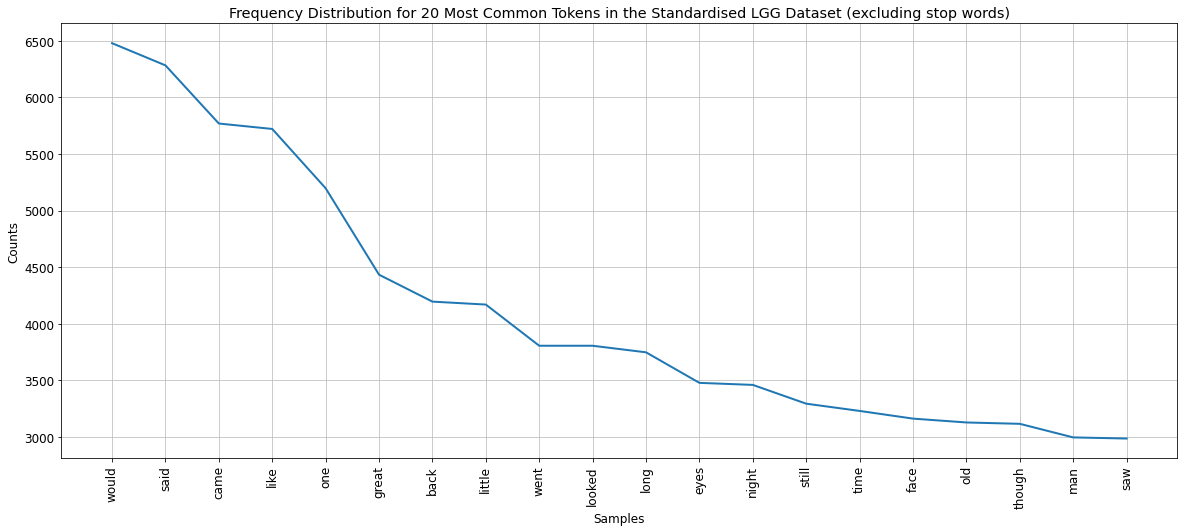

In [20]:
fdist_filtered_lower = FreqDist(filtered_lower)
plt.figure(figsize = (20, 8))
plt.rc('font', size=12)
number_of_tokens = 20 # Try increasing or decreasing this number to view more or fewer tokens in the visualization
fdist_filtered_lower.plot(number_of_tokens, title='Frequency Distribution for ' + str(number_of_tokens) + ' Most Common Tokens in the Standardised LGG Dataset (excluding stop words)')

Next, we can look at multiple words at a time.  Using `collocations()`, we can see which pairs of words occur together most often across the LGG dataset:

In [21]:
t.collocations()

GREY GRANITE; STAINED RADIANCE; LOST TRUMPET; Old Empire; THIRTEENTH
DISCIPLE; GAY HUNTER; CLOUD HOWE; Sir John; SUNSET SONG; Lady Jane;
Long Rob; ART ACU; EGYPTIAN NIGHTS; Abu Zabal; thousand years; PERSIAN
DAWNS; New Empire; George Shaw; Ake Ogilvie; ben Sanballat


``thousand years`` is a common **bigram**, or word pair.  I wonder what other words appear in similar contexts to the word `year`...

In [22]:
t.similar('years')

days months time hours men that life night things miles and it him
women slaves water â day others them


Let's pick a single work of Gibbon's to and see what its collocations are:

In [23]:
sunset_song = '205174251.txt'
sunset_song_words = wordlists.words(sunset_song)
s = Text(sunset_song_words)
s.collocations()

SUNSET SONG; Long Rob; John Guthrie; Bridge End; Mistress Melon; young
Ewan; Maggie Jean; Reverend Gibbon; John Brigson; Mistress Munro; Chae
Strachan; Standing Stones; folk said; come back; God knows; next day;
Ewan Tavendale; Uncle Tam; Mistress Strachan; Alec Mutch


Many of the most common bigrams are names!

#### 2.2 Uniqueness and Variety

To measure the uniqueness and variety of words in Gibbon's works, we can calculate the **lexical diversity** of files in the LGG dataset.  Lexical diversity measures the diversity of word choice, calculated by dividing the number of unique words by the total number of words in a work.  Instead of simply counting the number of unique words in each of Gibbon's works, we divide by the total number of words in a work to *normalise* the metric, so we can compare the diversity of word choice of works that are of different lengths.  Let's calculate the lexical diversity for each file in the LGG dataset and add this metric to our inventory DataFrame:

In [24]:
# INPUT: wordlists and the fileid of the wordlist to be tokenised
# OUTPUT: a list of word tokens (in String format) for the inputted fileid
def getWords(plaintext_corpus_read_lists, fileid):
    file_words = plaintext_corpus_read_lists.words(fileid)
    str_words = [str(word) for word in file_words if word.isalpha()]    
    return str_words

In [25]:
words_by_file = []
for file in fileids:
    words_by_file += [getWords(wordlists, file)]

In [26]:
# INPUT: a list of words in String format
# OUTPUT: the number of unique words divided by
#         the total words in the inputted list
def lexicalDiversity(str_words_list):
    return len(set(str_words_list))/len(str_words_list)

In [27]:
lexdiv_by_file = []
for words in words_by_file:
    lexdiv_by_file += [lexicalDiversity(words)]

df['lexicaldiversity'] = lexdiv_by_file
df_lexdiv = df.sort_values(by=['lexicaldiversity', 'title'], inplace=False, ascending=True)
df_lexdiv

,fileid,title,lexicaldiversity
10,205174251.txt,Scots quair - Sunset song - NF.523.b.29,0.072128
8,205174249.txt,Scots quair - Cloud howe - NF.523.b.30,0.078885
6,205174247.txt,Spartacus - Vts.6.k.19,0.099382
9,205174250.txt,Scots quair - Grey granite - NF.523.b.31,0.102243
5,205174246.txt,Image and superscription - Vts.118.l.16,0.117871
2,205174243.txt,Three go back - Vts.152.f.22,0.119819
14,205174255.txt,Gay hunter - Vts.215.j.26,0.121485
12,205174253.txt,Nine against the unknown - S.72.d.10,0.123527
0,205174241.txt,Niger - R.176.i,0.129199
3,205174244.txt,Calends of Cairo - Vts.153.c.16,0.130086


In [28]:
print("Lexical diversity of the entire LGG dataset: ", lexicalDiversity(lgg_words_lower))

Lexical diversity of the entire LGG dataset:  0.034381642818617345


To make it easier to compare the lexical diversity scores, let's visualise them!

In [29]:
sorted_titles = list(df_lexdiv['title'])
sorted_lexdiv = list(df_lexdiv['lexicaldiversity'])
source = pd.DataFrame({
    'Title': sorted_titles,
    'Lexdiv': sorted_lexdiv
})

alt.Chart(source, title="Lexical Diversity of Gibbon's Works").mark_bar(size=30).encode(
    alt.X('Title', axis=alt.Axis(title='Lewis Grassic Gibbon Work'), type='nominal', sort=None),  # If sort unspecified, chart will sort x-axis values alphabetically
    alt.Y('Lexdiv', axis=alt.Axis(format='%', title='Lexical Diversity')),
    alt.Order(
      # Sort the segments of the bars by this field
      'Lexdiv',
      sort='ascending'
    )
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).properties(
    width=500
)


alt.Chart(...)

This makes it clear that *Hanno, or, The future of exploration* is by far the most lexically diverse in the collection.  Interestingly, this was the [first book](https://digital.nls.uk/lewis-grassic-gibbon-books/archive/205174252#?c=0&m=0&s=0&cv=0&xywh=-1008%2C-135%2C3640%2C2698) he wrote (it was published in 1928)!

### 3. Exploratory Analysis

#### 3.1 How does Gibbon's word choice evolve throughout his publishing life?
Using information from the [digital.nls.uk](digital.nls.uk) website, we can quickly find and add the publication dates to Gibbon's works.  Since this LGG dataset is first editions, we know that the publication dates of Gibbon's books at the NLS will be the initial, original dates.

In [30]:
published = [1932, 1933, 1933, 1934, 1933, 1932, 1934, 1934, 1934, 1931, 1932, 1934, 1932, 1930, 1931, 1928]
df_lexdiv['published'] = published
df_pub = df_lexdiv.sort_values(by=['published', 'title'], inplace=False, ascending=True)
df_pub.head()

,fileid,title,lexicaldiversity,published
11,205174252.txt,"Hanno, or, The future of exploration - S.114.j.21",0.258565,1928
15,205202834.txt,Stained radiance - T.204.f,0.148124,1930
3,205174244.txt,Calends of Cairo - Vts.153.c.16,0.130086,1931
1,205174242.txt,Thirteenth disciple - Vts.137.d,0.151357,1931
4,205174245.txt,Lost trumpet - Vts.143.j.8,0.132837,1932


Now let's create another visualisation of the lexical diversity of Gibbon's works, but this time we'll sort the data by chronologically by `published` date:

In [31]:
sorted_titles = list(df_pub['title'])
sorted_lexdiv = list(df_pub['lexicaldiversity'])
sorted_published = list(df_pub['published'])
source = pd.DataFrame({
    'Title': sorted_titles,
    'Lexdiv': sorted_lexdiv,
    'Published': sorted_published
})

alt.Chart(source, title="Lexical Diversity of Gibbon's Works").mark_bar(size=30).encode(
    alt.X('Title', axis=alt.Axis(title='Title of Lewis Grassic Gibbon Work'), type='nominal', sort=None),  # If sort unspecified, chart will sort x-axis values alphabetically
    alt.Y('Lexdiv', axis=alt.Axis(format='%', title='Lexical Diversity')),
    alt.Order(
      # Sort the segments of the bars by this field
      'Lexdiv',
      sort='descending'
    ),
    color=alt.Color('Published:O', legend = alt.Legend(title='Date Published')),
    tooltip='Title:N'
).configure_axis(
    grid=False,
    labelFontSize=12,
    titleFontSize=12,
    labelAngle=-45
).configure_title(
    fontSize=14,
).configure_view(
    strokeWidth=0
).properties(
    width=500
)


alt.Chart(...)

Since we don't know the months in which Gibbon's works were published, let's calculate Gibbon's yearly lexical diversity to get a better sense of the trend over time.

**Step 1:** First, we need to group Gibbon's works by the year in which they were published:

In [32]:
pub_yr = {1928: [], 1930: [], 1931: [], 1932: [], 1933: [], 1934: []}
for index,row in df_pub.iterrows():
    pub_yr[row[3]] += [row[0]]
print(pub_yr)

{1928: ['205174252.txt'], 1930: ['205202834.txt'], 1931: ['205174244.txt', '205174242.txt'], 1932: ['205174245.txt', '205174248.txt', '205174251.txt', '205174243.txt'], 1933: ['205174246.txt', '205174249.txt', '205174247.txt'], 1934: ['205174254.txt', '205174255.txt', '205174241.txt', '205174253.txt', '205174250.txt']}


Perfect!

**Step 2:** Now we'll calculate the lexical diversity across all works published each year from 1928 through 1934 (excluding 1929, since the LGG dataset doesn't include any works published that year):

In [33]:
lexdiv_by_year = []
for key,value in pub_yr.items():
    lexdiv_by_file = []
    for fileid in value:
        file_words = wordlists.words(fileid)
        str_words = [str(w.lower()) for w in file_words if w.isalpha()]
        lexdiv_by_file += [lexicalDiversity(str_words)]
    lexdiv_by_year += [sum(lexdiv_by_file)/len(lexdiv_by_file)]
print(lexdiv_by_year)

[0.23601900972590628, 0.13228779469423085, 0.1292755998169271, 0.10706277290694641, 0.09077813517219867, 0.11163986470867093]


In [34]:
pub_years = [1928, 1930, 1931, 1932, 1933, 1934]
pub_lex = dict(zip(pub_years, lexdiv_by_year))
pub_lex

{1928: 0.23601900972590628,
 1930: 0.13228779469423085,
 1931: 0.1292755998169271,
 1932: 0.10706277290694641,
 1933: 0.09077813517219867,
 1934: 0.11163986470867093}

In [35]:
source = pd.DataFrame({
    'Year': pub_years,
    'Average Lexical Diversity': lexdiv_by_year
})

alt.Chart(source, title="Average Yearly Lexical Diversity of Gibbon First Editions").mark_bar(size=60).encode(
    alt.X('Year', axis=alt.Axis(title='Year of Publication'), type='ordinal'),
    alt.Y('Average Lexical Diversity', axis=alt.Axis(format='%', title='Average Lexical Diversity'))
).configure_axis(
    grid=False,
    labelFontSize=12,
    titleFontSize=12,
    labelAngle=0
).configure_title(
    fontSize=14,
).configure_view(
    strokeWidth=0
).properties(
    width=365
)


alt.Chart(...)

So Gibbon's lexical diversity does decrease over time, excepting a small increase in the last year he published, 1934!